# Models

> This shows how to define torch modules for differential equations 

In [ ]:
#| default_exp models

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export 
import torch 
import torch.nn as nn
if torch.cuda.is_available():
    # If you have a gpu then integrate with adjoint method
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint
import pylab as plt
from torch.utils.data import Dataset, DataLoader
from typing import Callable, List, Tuple, Union, Optional

## Define the VDP Oscillator

We can define a differential equation system using the `torch.nn.Module` class where the parameters are created using the `torch.nn.Parameter` 
declaration. This lets pytorch know that we want to accumulate gradients for those parameters. We can also include static parameters by just not wrapping them with this declaration. 

The classic VDP oscillator is a nonlinear oscillator with a single parameter $\mu$. We will recover this parameter from simulated data using the `training` module.

In [ ]:
#| exports 

class VDP(nn.Module):
    """ 
    Define the Van der Pol oscillator as a PyTorch module.
    """
    def __init__(self, 
                 mu: float, # Stiffness parameter of the VDP oscillator
                 ):
        super().__init__() 
        self.mu = torch.nn.Parameter(torch.tensor(mu))
        
    def forward(self, 
                t: float, # time index
                state: torch.TensorType, # state of the system first dimension is the batch size
                ) -> torch.Tensor:
        x = state[:, 0]
        y = state[:, 1]
        dX = self.mu*(x-1/3*x**3 - y)
        dY = 1/self.mu*x
        dfunc = torch.zeros_like(state)
        dfunc[:, 0] = dX
        dfunc[:, 1] = dY
        return dfunc
    
    def __repr__(self):
        return f" mu: {self.mu.item()}"
    
    
        
        

Let's see how we can integrate this model using torchdiffeq methods

(1000, 30, 2)
torch.Size([30, 2])


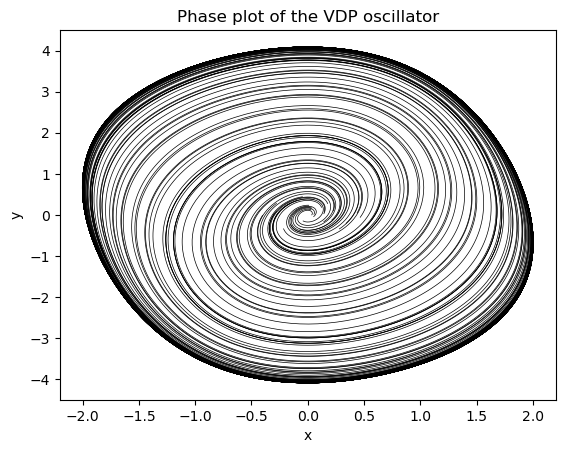

In [ ]:
vdp_model = VDP(mu=0.5)
ts = torch.linspace(0,30.0,1000)
# Create a batch of initial conditions 
batch_size = 30
initial_conditions = torch.tensor([0.01, 0.01]) + 0.2*torch.randn((batch_size,2))
sol = odeint(vdp_model, initial_conditions, ts, method='dopri5').detach().numpy()

# Check the solution
plt.plot(sol[:,:,0], sol[:,:,1], color='black', lw=0.5);
plt.title("Phase plot of the VDP oscillator");
plt.xlabel("x");
plt.ylabel("y");


The solution comes back as a torch tensor with dimensions (time_points, batch, dynamical_dimension). 

In [ ]:
sol.shape

(1000, 30, 2)

## Define the Lorenz system 

This defines a the famous Lorenz differential equations which give chaotic dynamics for the default parameter values
as shown. 

In [ ]:
#| exports

class Lorenz(nn.Module):
    """ 
    Define the Lorenz system as a PyTorch module.
    """
    def __init__(self, 
                 sigma: float =10.0, # The sigma parameter of the Lorenz system
                 rho: float=28.0, # The rho parameter of the Lorenz system
                beta: float=8.0/3, # The beta parameter of the Lorenz system
                ):
        super().__init__() 
        self.model_params = torch.nn.Parameter(torch.tensor([sigma, rho, beta]))
        
        
    def forward(self, t, state):
        x = state[:,0]      #variables are part of vector array u 
        y = state[:,1]
        z = state[:,2]
        sol = torch.zeros_like(state)
        
        sigma, rho, beta = self.model_params    #coefficients are part of vector array p
        sol[:,0] = sigma*(y-x)
        sol[:,1] = x*(rho-z) - y
        sol[:,2] = x*y - beta*z
        return sol
    
    def __repr__(self):
        return f" sigma: {self.model_params[0].item()}, rho: {self.model_params[1].item()}, beta: {self.model_params[2].item()}"
    

This shows how to integrate this system and plot the results. You can see that close iniial conditions end up very far apart later in time

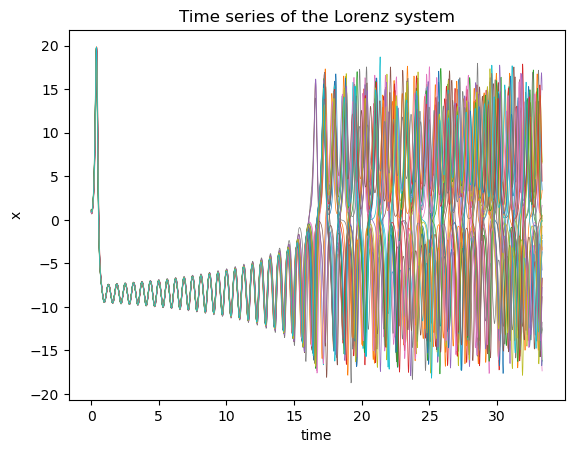

In [ ]:
lorenz_model = Lorenz()
ts = torch.linspace(0,50.0,3000)
# Create a batch of initial conditions (batch_dim, state_dim) as small perturbations around one value
initial_conditions = torch.tensor([[1.0,0.0,0.0]]) + 0.10*torch.randn((30,3))
sol = odeint(lorenz_model, initial_conditions, ts, method='dopri5').detach().numpy()
# Check the solution

plt.plot(ts[:2000], sol[:2000,:,0], lw=0.5);
plt.title("Time series of the Lorenz system");
plt.xlabel("time");
plt.ylabel("x");

The solution comes back as a tensor with dimension (timepoints, batch, dynamical_dim). 

In [ ]:
sol.shape

(3000, 30, 3)

Here we show the famous butterfly plot for the first set of initial conditions in the batch. 

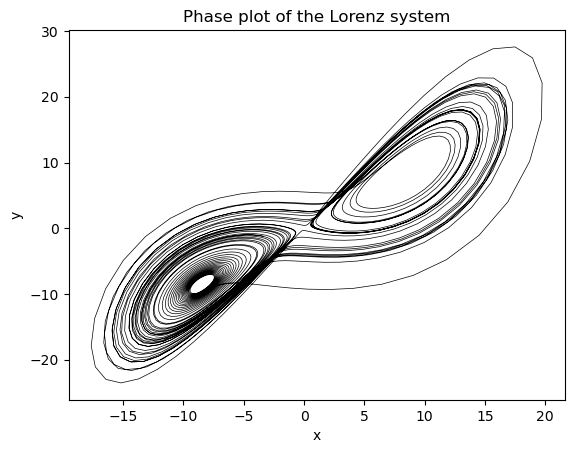

In [ ]:
plt.plot(sol[:,0,0], sol[:,0,1], color='black', lw=0.5);
plt.title("Phase plot of the Lorenz system");
plt.xlabel("x");
plt.ylabel("y");

## Define the Lotka Volterra Predator Prey equations 

As another example we create a module for the predator-prey equations.

In [ ]:
#| exports


class LotkaVolterra(nn.Module):
    """ 
     The Lotka-Volterra equations are a pair of first-order, non-linear, differential equations
     describing the dynamics of two species interacting in a predator-prey relationship.
    """
    def __init__(self,
                 alpha: float = 1.5, # The alpha parameter of the Lotka-Volterra system
                 beta: float = 1.0, # The beta parameter of the Lotka-Volterra system
                 delta: float = 3.0, # The delta parameter of the Lotka-Volterra system
                 gamma: float = 1.0 # The gamma parameter of the Lotka-Volterra system
                 ) -> None:
        super().__init__()
        self.model_params = torch.nn.Parameter(torch.tensor([1.5,1.0,3.0,1.0]))
        
        
    def forward(self, t, state):
        x = state[:,0]      #variables are part of vector array u 
        y = state[:,1]
        sol = torch.zeros_like(state)
        
        alpha, beta, delta, gamma = self.model_params    #coefficients are part of vector array p
        sol[:,0] = alpha*x - beta*x*y
        sol[:,1] = -delta*y + gamma*x*y
        return sol
    
    def __repr__(self):
        return f" alpha: {self.model_params[0].item()}, beta: {self.model_params[1].item()}, delta: {self.model_params[2].item()}, gamma: {self.model_params[3].item()}"


Integrate and make the same plots as the other systems

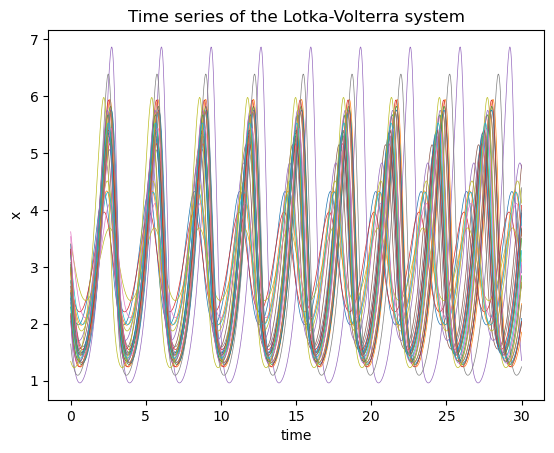

In [ ]:
lv_model = LotkaVolterra()
ts = torch.linspace(0,30.0,1000)
# Create a batch of initial conditions (batch_dim, state_dim) as small perturbations around one value
initial_conditions = torch.tensor([[3,3]]) + 0.50*torch.randn((30,2))
sol = odeint(lv_model, initial_conditions, ts, method='dopri5').detach().numpy()
# Check the solution

plt.plot(ts, sol[:,:,0], lw=0.5);
plt.title("Time series of the Lotka-Volterra system");
plt.xlabel("time");
plt.ylabel("x");

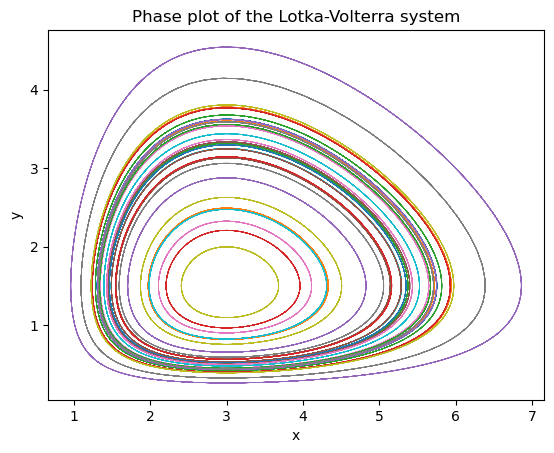

In [ ]:
plt.plot(sol[:,:,0], sol[:,:,1], lw=0.5);
plt.title("Phase plot of the Lotka-Volterra system");
plt.xlabel("x");
plt.ylabel("y");

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()